# Projecting WRF data

This notebook demonstrates how to create the coordinate reference system information for a set of WRF outputs using the standard WRF "geogrid" file (`geo_em.d01.nc`) associated with those particular runs.


There are multiple different map projections available for the WRF model. [This webpage](https://www.ncl.ucar.edu/Applications/wrflc.shtml) provides the following mapping from integer WRF "MAP_PROJ" codes to the map projection types:  

* MAP_PROJ = 0 --> "CylindricalEquidistant"  
* MAP_PROJ = 1 --> "LambertConformal"  
* MAP_PROJ = 2 --> "Stereographic"  
* MAP_PROJ = 3 --> "Mercator"  
* MAP_PROJ = 6 --> "Lat/Lon"  

This notebook will demonstrate deriving the projection information for the "LambertConformal" and the "Stereographic" using two different methods that are very similar. They are really just two different ways to go about getting the required proj4 string for the WRF grid.

Once the proj4 string is created, deriving the coordinate values is done the same way, so this notebook will make use of some functions for computing the grids and validating with the available longitude and latitudes. The first function will take as arguments the newly created WRF projection information and the geogrid file, and return the 2D grids of x and y values corresponding to the centerpoints of the WRF grid cells in projected space:

In [1]:
def compute_grid(wrf_proj, geo_ds):
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(wgs_proj, wrf_proj)

    # Easting and Northings of the domains center point
    e, n = transformer.transform(geo_ds.CEN_LON, geo_ds.CEN_LAT)
    # Grid parameters
    dx, dy = geo_ds.DX, geo_ds.DY
    nx, ny = geo_ds.dims['west_east'], geo_ds.dims['south_north']
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n
    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    return xx, yy

The second function will backtransform the x / y values of the WRF gril cell centerpoints to longitude and latitudes and compute the error as distances between these points and the original points supplied as lat / lon geolocation grids in the geogrid file, returning a 2D array of error values:

In [2]:
def compute_error(wrf_proj, xx, yy):
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(wrf_proj, wgs_proj)
    our_lons, our_lats = transformer.transform(xx, yy)
    error_arr = np.sqrt((our_lons - geo_ds.XLONG_M)**2 + (our_lats - geo_ds.XLAT_M)**2)
    
    return error_arr.values[0]

This function will visualize the error with a heatmap and histogram:

In [3]:
def plot_error(error_arr):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    im = axs[0].imshow(error_arr, interpolation="none")
    plt.colorbar(im, ax=axs[0], orientation="horizontal")
    axs[1].hist(error_arr.flatten())
    plt.show()
    
    return

Also, the following imports are used for both methods:

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer

## Method 1 - manual proj4 specification

This method draws heavily on [this blog post: "Map projections in WRF: it's easy to get it wrong" by Fabien Maussion](https://fabienmaussion.info/2018/01/06/wrf-projection/) for achieving the desired outcome - thank you Fabien! It involves manually creating a proj4 string from the values in the geogrid file.

Read in the geogrid file used for the WRF runs. This geogrid file was used for 1km WRF runs for the SERDP project, using a lambert conformal conic projection:

In [5]:
# for SNAP reference
#cp /workspace/Shared/Tech_Projects/SERDP_Fish_Fire/project_data/wrf/geo_em.d01.nc data/wrf_geogrid_1km_serdp_interior.nc

In [6]:
geo_ds = xr.open_dataset("data/wrf_geogrid_1km_serdp_interior.nc")

In [7]:
geo_ds.attrs["MAP_PROJ"]

1

This confirms that the projection used in this WRF configuration is a lambert conformal conic. Create the `Proj` class instance for reprojecting lat/lon of WRF grid centerpoint to WRF CRS:

**Note** - information here can mostly be discerned from the [`pyproj` projections page on the lambert conformal conic projection](https://proj.org/operations/projections/lcc.html).

In [8]:
# create the WRF projection
wrf_proj = Proj(
    proj="lcc", # projection type: Lambert Conformal Conic
    lat_1=geo_ds.TRUELAT1, lat_2=geo_ds.TRUELAT2, # Cone intersects with the sphere
    lat_0=geo_ds.MOAD_CEN_LAT, lon_0=geo_ds.STAND_LON, # Center point
    a=6370000, b=6370000 # This is it! The Earth is a perfect sphere
) 
# WGS 
wgs_proj = Proj(proj='latlong', datum='WGS84')

Generate the coordinates in WRF grid space from the centerpoint:

**Note** - this notebook makes use of `pyproj v2.x` and `pyproj.transformer.Transformer`, unlike the original post linked above. 

In [9]:
xx, yy = compute_grid(wrf_proj, geo_ds)

View the generated coordinates:

In [10]:
print(xx)
print("\nShape: ", xx.shape)

[[105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 ...
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]
 [105649.04357427 106649.04357427 107649.04357427 ... 441649.04357427
  442649.04357427 443649.04357427]]

Shape:  (209, 339)


In [11]:
print(yy)
print("\nShape: ", xx.shape)

[[-94340.95982198 -94340.95982198 -94340.95982198 ... -94340.95982198
  -94340.95982198 -94340.95982198]
 [-93340.95982198 -93340.95982198 -93340.95982198 ... -93340.95982198
  -93340.95982198 -93340.95982198]
 [-92340.95982198 -92340.95982198 -92340.95982198 ... -92340.95982198
  -92340.95982198 -92340.95982198]
 ...
 [111659.04017802 111659.04017802 111659.04017802 ... 111659.04017802
  111659.04017802 111659.04017802]
 [112659.04017802 112659.04017802 112659.04017802 ... 112659.04017802
  112659.04017802 112659.04017802]
 [113659.04017802 113659.04017802 113659.04017802 ... 113659.04017802
  113659.04017802 113659.04017802]]

Shape:  (209, 339)


Re-compute the lats and lons for a quick validation:

In [12]:
error_arr = compute_error(wrf_proj, xx, yy)

View the error between the re-computed lats and lons and original lats/lons:

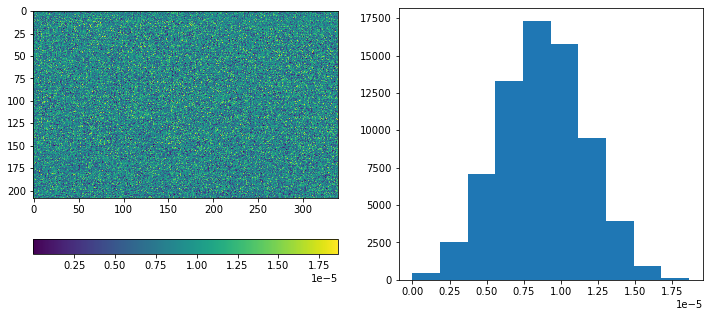

In [13]:
plot_error(error_arr)

Error looks good - white noise! 

#### Add coordinates to a file

(This will only be demonstrated for this case)

Load in a file to add these coordinates to:

In [14]:
# sample WRF file provided by Peter
wrf_ds = xr.open_dataset("t2_1km_2008-17_dera_climo.nc")

Assign the coordinates to the xarray dataset:

In [15]:
# rename dims and assign new coords
new_ds = wrf_ds.rename_dims({"south_north": "y", "west_east": "x"})
new_ds = new_ds.assign_coords({"y": ("y", yy[:,0]), "x": ("x", xx[0,:])})

Plot a sample slice:

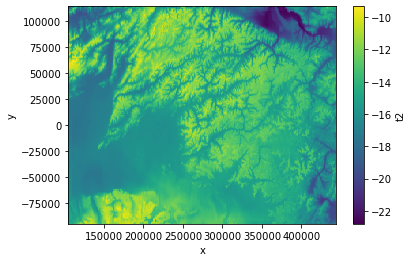

In [16]:
new_ds.t2.sel(time=1).plot()

And write the file:

In [17]:
new_ds.to_netcdf("t2_1km_2008-17_dera_climo_projected.nc")

## Method 2 - create proj4 spec with `wrf-python`

The import below imports the [`wrf-python`](https://wrf-python.readthedocs.io/en/latest/index.html) package, which can be used to create a proj4 string using the available `WrfProj` subclasses.

In [18]:
from wrf import LambertConformal

Create the proj4 string which can the be interpreted by `pyproj.Proj`:

In [19]:
wrf_vars = ["TRUELAT1", "TRUELAT2", "MOAD_CEN_LAT", "STAND_LON", "POLE_LAT", "POLE_LON"]
wrf_proj_str = LambertConformal(**{var: geo_ds.attrs[var] for var in wrf_vars}).proj4()
print(wrf_proj_str)

+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=64.79986572265625 +lon_0=-152.0 +nadgrids=@null


Then convert to `Proj` object and do the same as before:

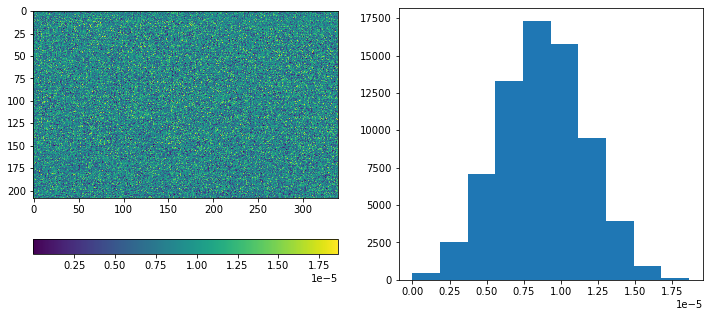

In [20]:
wrf_proj = Proj(wrf_proj_str)
xx, yy = compute_grid(wrf_proj, geo_ds)
error_arr = compute_error(wrf_proj, xx, yy)
plot_error(error_arr)

### Stereographic example

This package has proven useful for other map projections with WRF for which there is not a clear mapping between the required proj4 pieces and the geogrid parameters. The example below demonstrates this method with the 20km Alaska WRF, which was done on a Stereographic projection.

Read in the geogrid file from the 20km WRF runs over Alaska:

In [21]:
# for SNAP reference
#cp /rcs/project_data/ancillary_wrf_constants/geo_em.d01.nc data/wrf_geogrid_20km_alaska.nc

In [22]:
geo_ds = xr.open_dataset("data/wrf_geogrid_20km_alaska.nc")
geo_ds.attrs["MAP_PROJ"]

2

Reference the table above to confirm that this WRF configuration used a stereographic projection. 

Load the `PolarSteregraphic` projection class from `wrf`:

In [24]:
from wrf import PolarStereographic

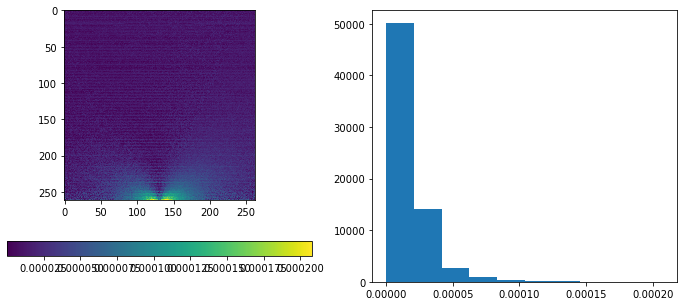

In [25]:
wrf_vars = ["TRUELAT1", "TRUELAT2", "MOAD_CEN_LAT", "STAND_LON", "POLE_LAT", "POLE_LON"]
wrf_proj_str = PolarStereographic(**{var: geo_ds.attrs[var] for var in wrf_vars}).proj4()
wrf_proj = Proj(wrf_proj_str)
xx, yy = compute_grid(wrf_proj, geo_ds)
error_arr = compute_error(wrf_proj, xx, yy)
plot_error(error_arr)

While there is more pattern in this error, most of the error here is only on the order of 0.00001 degrees, or approximately ~1-10m. It makes sense that things might start to break down a little more with the re-projection as we get closer to the north pole, which is the bottom of the error array in this case.

The `wrf-python` package has proven to be the simplest way to project WRF data.